In [53]:
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
from shapely import wkt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd
from utils.visualization.label_to_color import LabelDict


In [54]:
from xml.etree.ElementInclude import include


def build_weights_table(out_path: FilePath) -> pd.DataFrame:
    w_json = out_path.join("train_weights.json")
    w_dict = w_json.read_json()
    w_dict = w_dict.get("dmg", w_dict)
    w_row = [[cls_name, round(wei)] for cls_name, wei in w_dict.items()]
    return pd.DataFrame(w_row, columns=["Class", "Weight"])


def build_conf_table(out_path: FilePath):
    conf_json = out_path.join("conf_list.json")
    conf_list: dict = conf_json.read_json()
    rows = []
    for i, param_dict in conf_list:
        row = [f"Config {i}", param_dict["batch_size"],
               param_dict["learning_rate"], param_dict["tot_epochs"]]
        rows.append(row)
    return pd.DataFrame(rows, columns=["Number", "Batch size", "Learning rate", "Total epochs"])


def load_dfs(metric_dir: FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join("val_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch", "class"])
    dmg_df = pd.read_csv(metric_dir.join("val_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch", "class"])
    loss_df = pd.read_csv(metric_dir.join("val_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df


def build_fold_table(out_path: FilePath):
    config_folders = [fol_name for fol_name in out_path.get_folder_names()
                      if fol_name.startswith("config")]
    fold_list = []
    for dir in config_folders:
        conf_path = out_path.join(dir)
        for fold in conf_path.get_folder_names():
            fold_dir = conf_path.join(fold)
            metric_dir = fold_dir.join("metrics/csv")
            bld_df, dmg_df, loss_df = load_dfs(metric_dir)
            c = dir[len(dir)-1]
            f = fold[len(fold)-1]
            best_f1_hm = dmg_df["f1_harmonic_mean"].max()
            best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
            val_loss = loss_df.loc[best_epoch].iloc[0]
            seg_f1 = bld_df.loc[best_epoch]["f1"].iloc[0]
            dmg_f1 = dmg_df.loc[best_epoch, 0]["f1"]
            seg_hf1 = 2 / ((1 / seg_f1) + (1 / dmg_f1))
            row = [f"C{c}", f"F{f}", best_epoch, val_loss, best_f1_hm, seg_hf1]
            fold_list.append(row)

    fold_df = pd.DataFrame(fold_list, columns=[
                           "Conf", "Fold", "Best epoch", "val-loss", "HMf1-dmg", "HFM1-seg"])
    fold_df = fold_df.sort_values(by=["Conf"])
    fold_df = round(fold_df, 4)
    fold_df = fold_df.groupby("Conf").apply(lambda x: x.set_index("Fold"), include_groups=False)
    fold_df = fold_df.sort_values(["Conf","Fold"])
    return fold_df


def plot_loss(tr_l: pd.DataFrame, vl_l: pd.DataFrame, step):
    # Renombrar las columnas para evitar confusiones
    tr_l = tr_l.rename(columns={"loss": "train_loss"})
    vl_l = vl_l.rename(columns={"loss": "val_loss"})
    f_df = pd.concat([tr_l, vl_l], axis=1)

    # Crear la figura y el eje, ajustando el tamaño
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Graficar las pérdidas de entrenamiento y validación
    ax.plot(f_df.index, f_df["train_loss"], label="Train Loss", linewidth=2)
    ax.plot(f_df.index, f_df["val_loss"], label="Validation Loss", linestyle='--', linewidth=2)

    # Título y etiquetas con fuentes más grandes
    # ax.set_title("Pérdida a lo largo de las épocas", fontsize=24)
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)

    # Aumentar el tamaño de la leyenda
    ax.legend(fontsize=24, loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1)

    ax.set_xticks(range(0, f_df.index.max()+1, step))

    # Añadir cuadrícula
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.show()


def plot_harmonic_mean(tr_m: pd.DataFrame, vl_m: pd.DataFrame, step):
    # Filtrar y procesar los datos de entrenamiento y validación para la clase 0
    tr = tr_m[tr_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    tr = tr.rename(columns={"f1_harmonic_mean": "f1_h_train"})
    tr = tr.set_index("epoch")


    vl = vl_m[vl_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    vl = vl.rename(columns={"f1_harmonic_mean": "f1_h_val"})
    vl = vl.set_index("epoch")

    # Concatenar los datos de entrenamiento y validación
    metrics_df = pd.concat([tr, vl], axis=1)

    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Graficar cada conjunto de datos por separado
    ax.plot(metrics_df.index, metrics_df['f1_h_train'],
            label='HMF1 de Entrenamiento', color='blue', linewidth=2)
    ax.plot(metrics_df.index, metrics_df['f1_h_val'],
            label='HMF1 de Validación', color='orange', linestyle='--', linewidth=2)

    # Configuración de título y etiquetas en español
    # ax.set_title('Media Armónica del F1 a lo largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=20)
    ax.set_ylabel('F1 Harmonic Mean', fontsize=20)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de la leyenda y configurarla adecuadamente
    ax.legend(fontsize=20, loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    plt.show()


def plot_metric_per_class(tr_m: pd.DataFrame, metric: str, step):
    
    # Convertir números de clase en nombres de clase
    tr_m['class'] = tr_m['class'].apply(lambda x: LabelDict().get_key_by_num(int(x)))

    # Pivotar los datos para tener épocas como índice y clases como columnas
    tr = tr_m.pivot(index='epoch', columns='class', values=metric)

    # puedes personalizar estos colores
    colors = ['#0f0f0f', '#ff1e1e', '#2ca02c', '#ffa500', '#808080']

    # Crear la figura y el eje con un DPI mejorado para mayor calidad
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

    # Graficar cada clase con un color y estilo de línea diferente
    for i, col in enumerate(tr.columns):
        ax.plot(tr.index, tr[col], label=col, linewidth=2, color=colors[i % len(colors)])

    # Configuración de título y etiquetas en español
    # ax.set_title(f'{metric.capitalize()} por Clase a lo Largo de las Épocas', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(f'{metric.capitalize()}', fontsize=14)

    # Configuración de la leyenda
    ax.legend(fontsize=14, loc='best', fancybox=True, framealpha=1, shadow=True, borderpad=1)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    plt.tight_layout()  # Ajustar automáticamente el diseño para que no se solapen elementos
    plt.show()


def load_metric_dfs(split, metric_dir: FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join(f"{split}_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch", "class"])
    dmg_df = pd.read_csv(metric_dir.join(f"{split}_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch", "class"])
    loss_df = pd.read_csv(metric_dir.join(f"{split}_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df


def build_subtable(split, best_epoch, bld_df, dmg_df, loss_df):
    # Computing hf1 for segmentation
    seg_f1 = bld_df.loc[best_epoch]["f1"].iloc[0]
    dmg_f1 = dmg_df.loc[best_epoch, 0]["f1"]
    seg_hf1 = 2 / ((1 / seg_f1) + (1 / dmg_f1))

    # Segmentation sub sub table
    seg_sub = pd.concat([dmg_df.loc[best_epoch].loc[[0]], bld_df.loc[best_epoch]])
    seg_sub.reset_index(inplace=True)
    seg_sub["class"] = ["background", "building"]
    seg_sub.set_index("class", inplace=True)
    seg_sub["hf1"] = seg_hf1
    seg_sub = seg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    seg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    # Classification sub sub table
    dmg_hf1 = dmg_df.loc[best_epoch]["f1_harmonic_mean"].iloc[0].copy()
    dmg_sub = dmg_df.loc[best_epoch].copy()
    dmg_sub["hf1"] = dmg_hf1
    dmg_sub.reset_index(inplace=True)
    dmg_sub["class"] = dmg_sub["class"].apply(LabelDict().get_key_by_num)
    dmg_sub.set_index("class", inplace=True)
    dmg_sub = dmg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    dmg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    subtable = pd.concat([seg_sub, dmg_sub])
    subtable["split"] = split
    subtable = subtable.groupby(["split"]).apply(lambda x: x, include_groups=False)
    subtable = round(subtable, 4)
    loss = loss_df.loc[best_epoch].iloc[0]
    loss = round(loss, 4)
    return subtable, loss


def build_val_test_table(path, fold_df, test_path = None):
    best_conf = fold_df["HMf1-dmg"].idxmax() if len(fold_df > 0) else 0
    val_metric_dir = path.join("definitive_model/metrics/csv/")
    val_bld_df, val_dmg_df, val_loss_df = load_metric_dfs('val', val_metric_dir)
    best_epoch = val_dmg_df["f1_harmonic_mean"].idxmax()[0]
    val_sub, val_loss = build_subtable(
        "validation", best_epoch, val_bld_df, val_dmg_df, val_loss_df)

    if test_path:
        test_metric_dir = path.join(test_path)
        test_bld_df, test_dmg_df, test_loss_df = load_metric_dfs('test', test_metric_dir)
        test_sub, test_loss = build_subtable("test", best_epoch, test_bld_df, test_dmg_df, test_loss_df)
        table = pd.concat([val_sub, test_sub])
        header = f"Mejor configuración = {best_conf} & Mejor época = {best_epoch} & val_loss = {val_loss} & test_loss = {test_loss}"
    else:
        header = f"Mejor configuración = {best_conf} & Mejor época = {best_epoch} & val_loss = {val_loss} \\\\"
        table = val_sub
    return header, table

# Experiment 1

In [55]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp1_mendieta/out")


In [56]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,15432
1,major-damage,890
2,minor-damage,230
3,no-damage,1


In [57]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,20
1,Config 1,16,0.0001,20
2,Config 2,32,0.0010,20
3,Config 3,32,0.0001,20


In [58]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            15    0.1173    0.0219    0.0201
     F1            17    0.1177    0.0258    0.0142
C1   F0            18    0.1188    0.0178    0.0122
     F1            20    0.1239    0.0093    0.0269
C2   F0             7    0.0656    0.0174    0.0107
     F1             6    0.0642    0.0187    0.0122
C3   F0            13    0.0638    0.0211    0.0153
     F1            19    0.0701    0.0279    0.0178

In [59]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df)
print(header)
table

Mejor configuración = ('C3', 'F1') & Mejor época = 18 & val_loss = 0.1037 \\


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.017500 background       0.0045  0.4686  0.0088    0.5774
                    building         1.0000  0.9845  0.9922    0.9945
           0.036256 background       0.0045  0.4686  0.0088    0.5774
                    no-damage        0.9985  0.6287  0.7716    0.8948
                    minor-damage     0.0342  0.9733  0.0660    0.9418
                    major-damage     0.1528  0.9326  0.2626    0.9967
                    destroyed        0.1682  0.3566  0.2285    0.9999

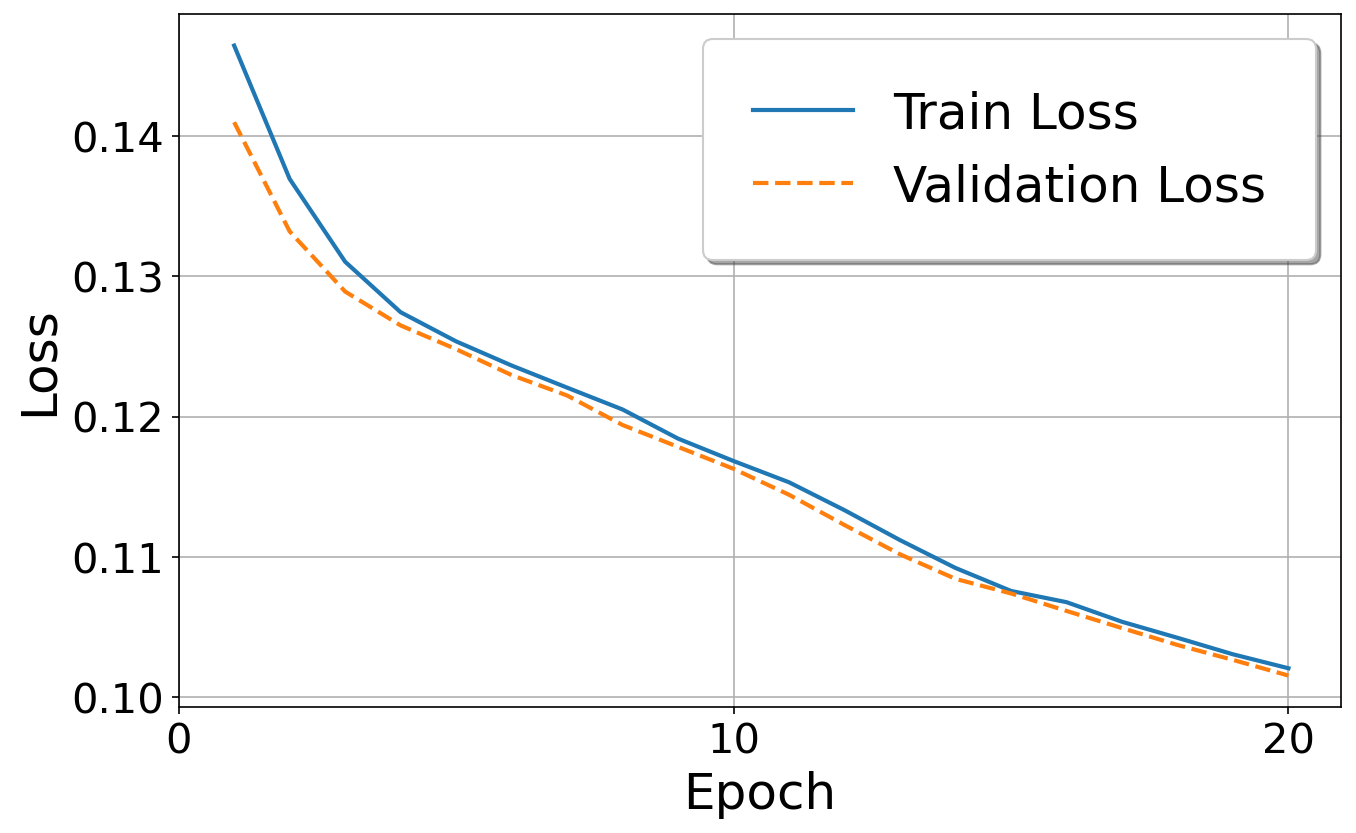

In [60]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


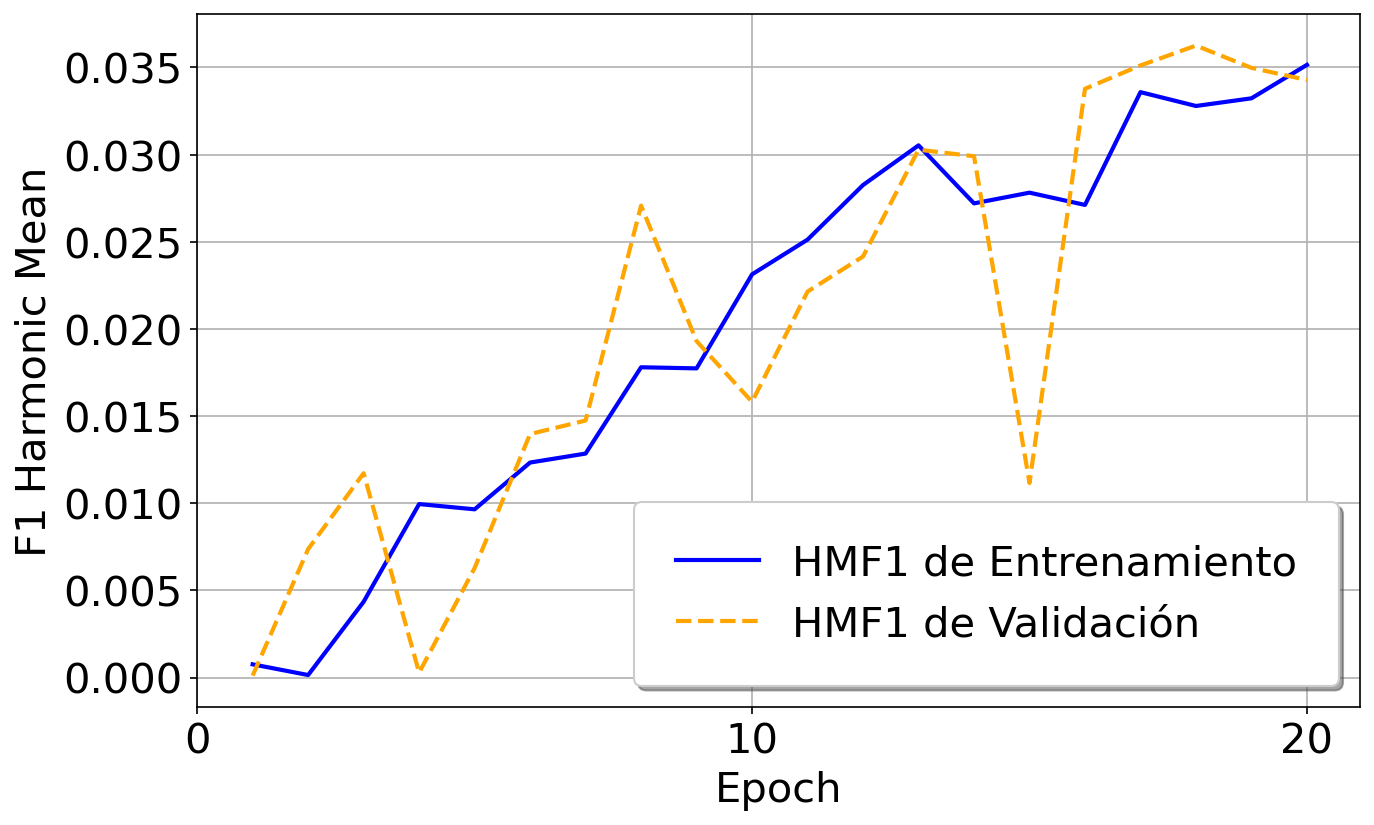

In [61]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

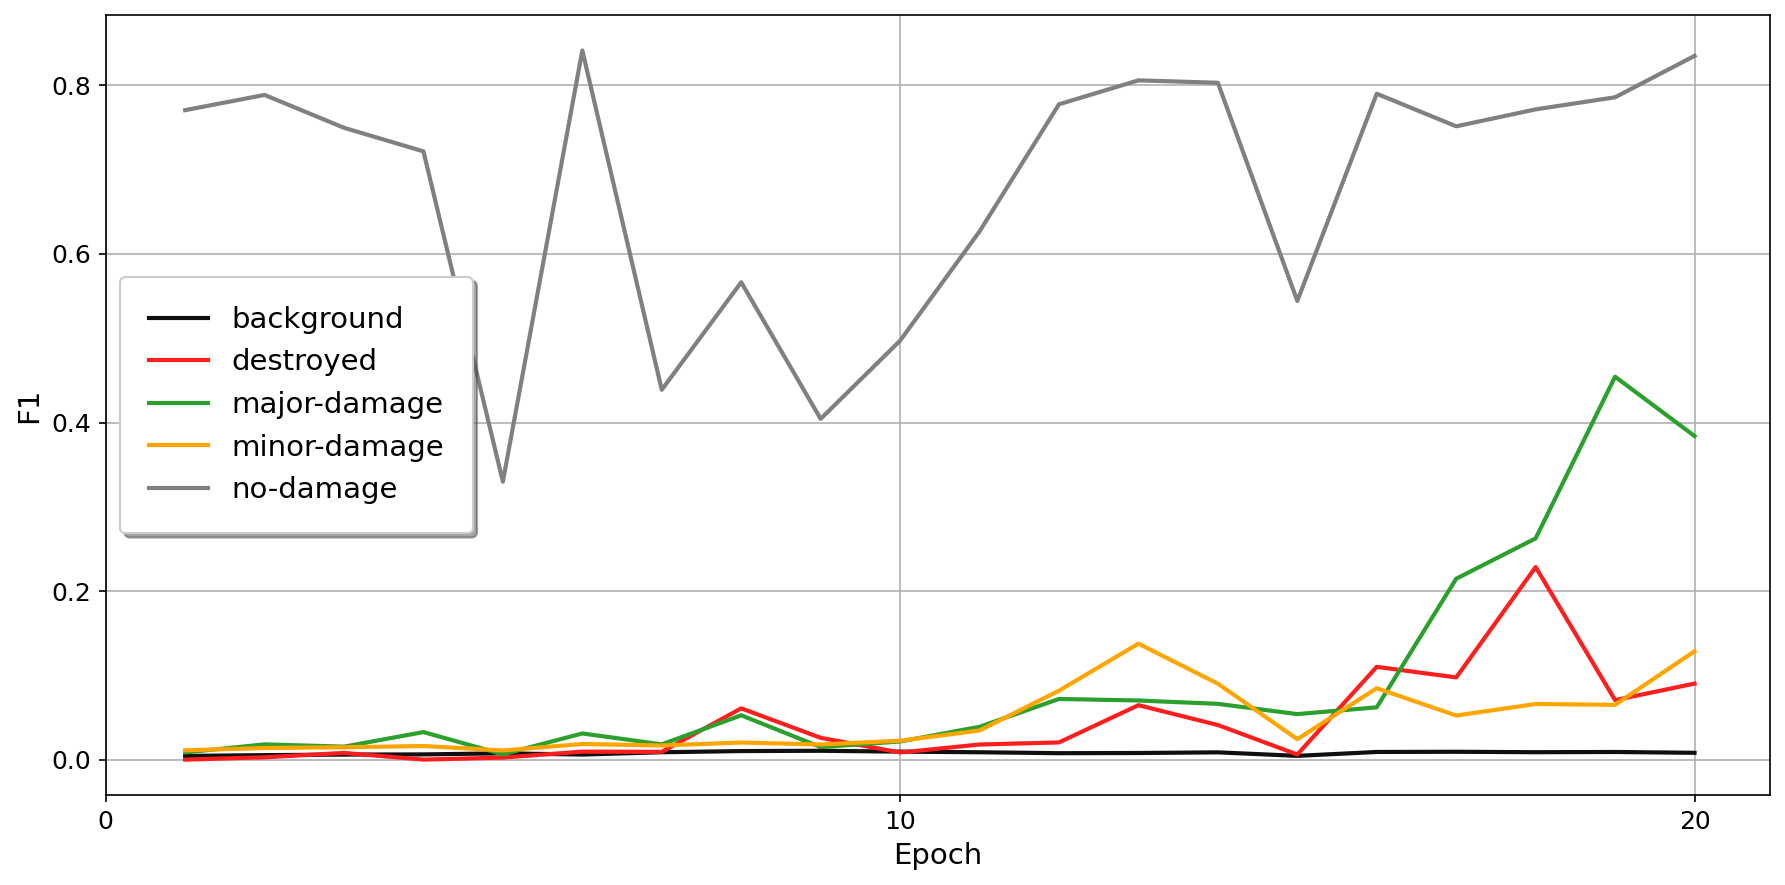

In [62]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",10)


# Experiment 2

In [63]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp2_not_aug/out")


In [64]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,15011
1,major-damage,850
2,minor-damage,223
3,no-damage,1


In [65]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,100
1,Config 1,16,0.0001,100
2,Config 2,32,0.0010,100
3,Config 3,32,0.0001,100
4,Config 4,64,0.0010,100
5,Config 5,64,0.0001,100


In [66]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            72    0.1053    0.0316    0.0169
     F1            90    0.1029    0.0360    0.0211
     F2            90    0.1036    0.0261    0.0145
     F3            11    0.1162    0.0125    0.0059
     F4            98    0.1060    0.0310    0.0163
C1   F0            56    0.0939    0.0224    0.0090
     F1            82    0.0962    0.0347    0.0229
     F2            58    0.0983    0.0179    0.0079
     F3            31    0.0991    0.0389    0.0203
     F4            61    0.0999    0.0342    0.0231
C2   F0            96    0.0514    0.0353    0.0188
     F1            98    0.0520    0.0186    0.0102
     F2            95    0.0559    0.0135    0.0084
     F3            66    0.0560    0.0239    0.0174
     F4            77    0.0569    0.0259    0.0280
C3   F0            16    0.0566    0.0205    0.0114
     F1            83    0.0479    0.0237    0.0098
     F2            22    0.0609    0.0386    0.0222
     F3            56    0.0508    0.0257    0.0124
     F4            57    0.0482    0.0179    0.0101
C4   F0            94    0.0256    0.0227    0.0169
     F1            28    0.0296    0.0176    0.0246
     F2            78    0.0270    0.0258    0.0189
     F3            81    0.0265    0.0189    0.0119
     F4            49    0.0294    0.0096    0.0149
C5   F0            94    0.0231    0.0371    0.0209
     F1            66    0.0250    0.0265    0.0145
     F2            11    0.0344    0.0157    0.0082
     F3            45    0.0259    0.0285    0.0135
     F4            61    0.0252    0.0316    0.0129

In [68]:
fold_df.idxmax()

Best epoch    (C0, F4)
val-loss      (C0, F3)
HMf1-dmg      (C1, F3)
HFM1-seg      (C2, F4)
dtype: object

In [15]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df, test_path)
print(header)
table

Mejor configuración = ('C1', 'F3') & Mejor época = 98 & val_loss = 0.0932 & test_loss = 0.1384


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.019742 background       0.0050  0.5809  0.0100    0.4974
                    building         1.0000  0.9930  0.9965    0.9976
           0.046885 background       0.0050  0.5809  0.0100    0.4974
                    no-damage        0.9992  0.7907  0.8828    0.9418
                    minor-damage     0.2647  0.9888  0.4177    0.9941
                    major-damage     0.4347  0.9855  0.6032    0.9992
                    destroyed        0.7875  0.9623  0.8662    1.0000
test       0.027717 background       0.0071  0.5905  0.0141    0.5178
                    building         1.0000  0.9792  0.9895    0.9902
           0.069172 background       0.0071  0.5905  0.0141    0.5178
                    no-damage        0.9950  0.7887  0.8799    0.9231
                    minor-damage     0.0000  0.0000  0.0000    0.9919
                    major-damage     0.0000  0.0000  0.0000    0.9988
                    destroyed        0.0000  0.0000  0.0000    1.0000

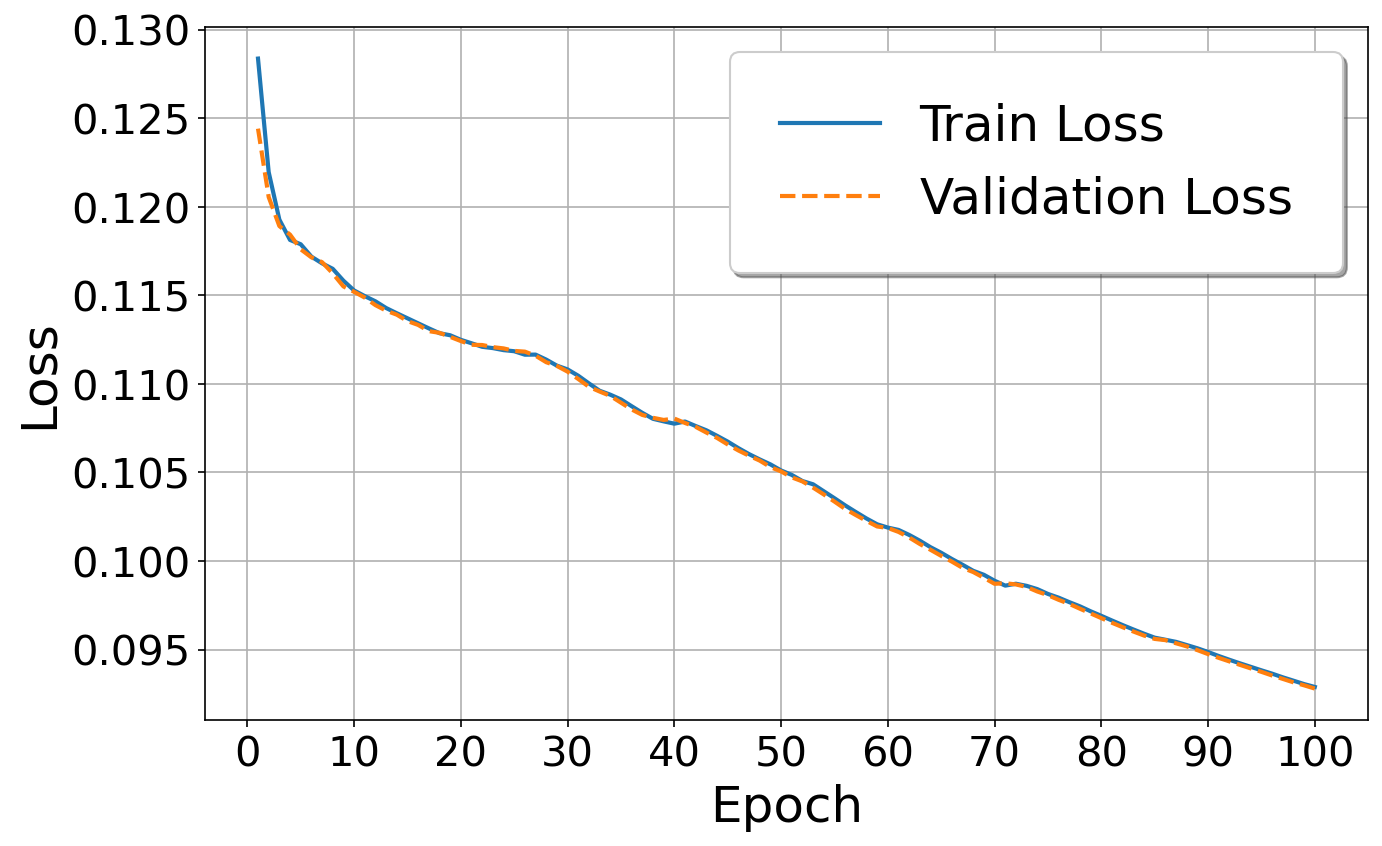

In [16]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


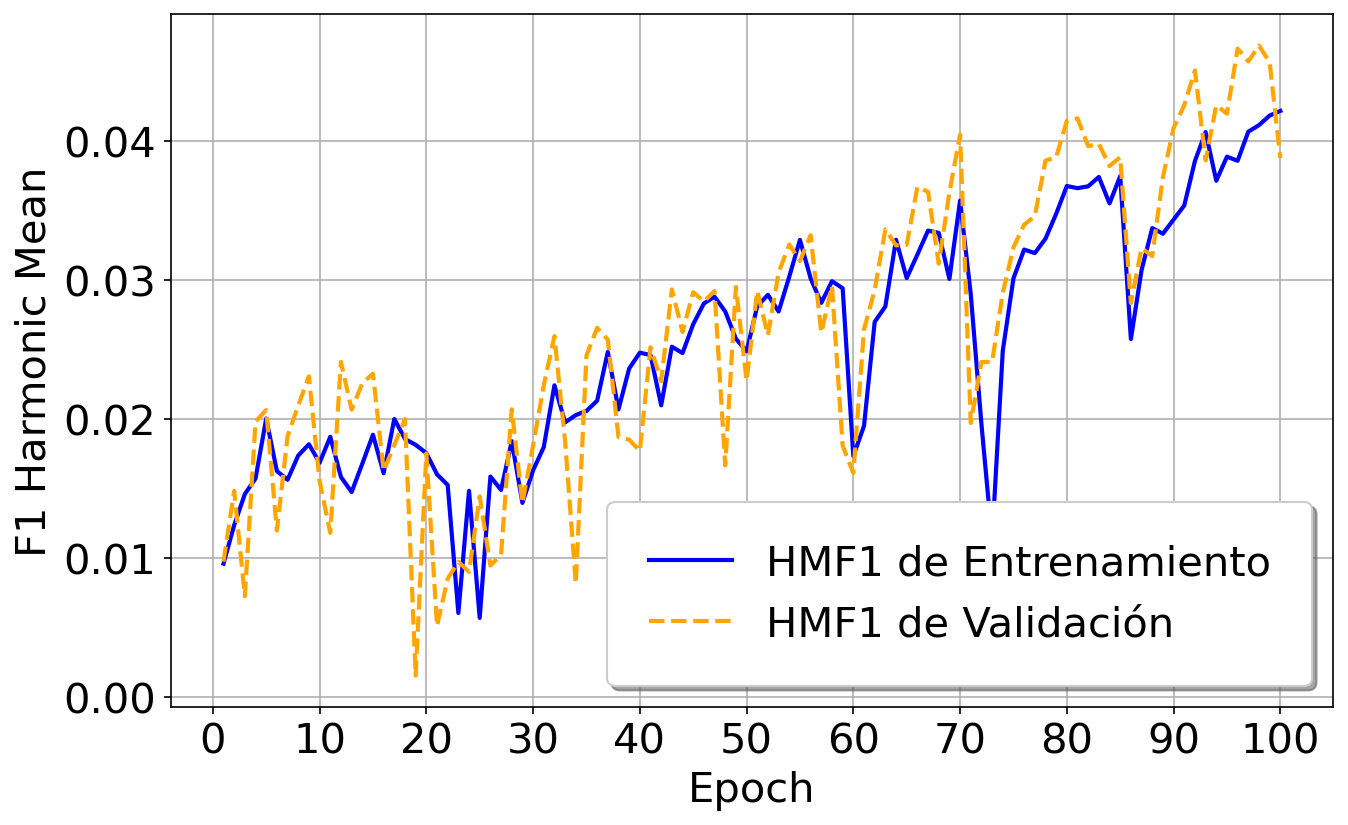

In [17]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

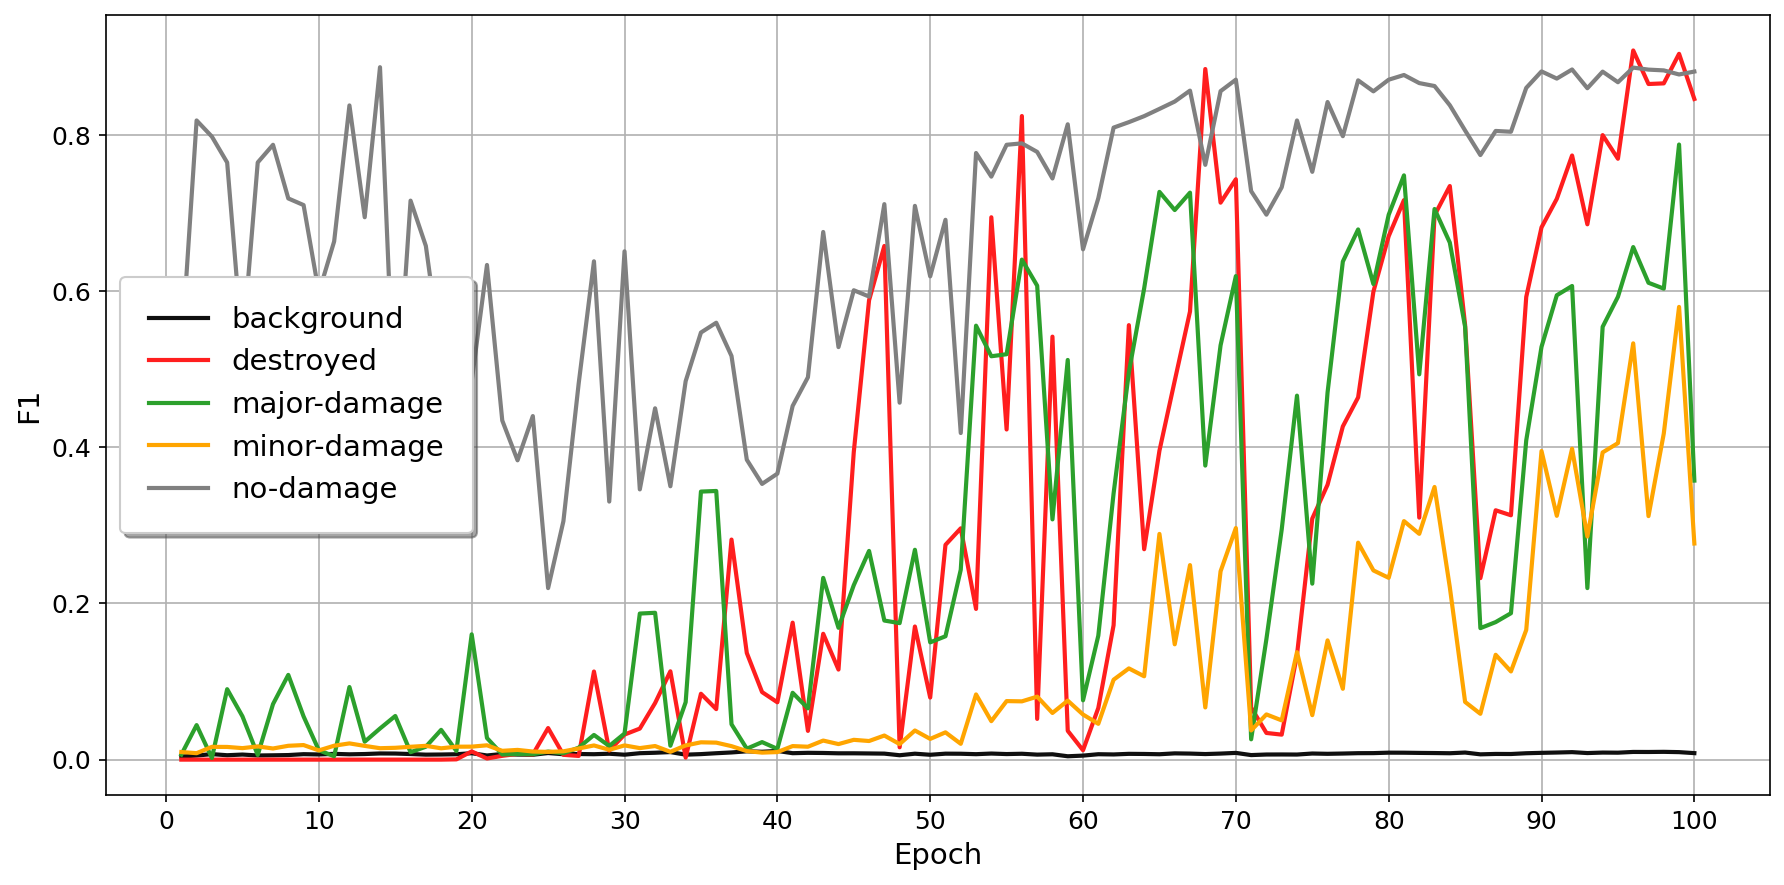

In [18]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",10)


# Experimento 3

In [19]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp3_aug/out")


In [20]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,destroyed,5
1,major-damage,5
2,minor-damage,5
3,no-damage,2


In [21]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.0010,100
1,Config 1,16,0.0001,100
2,Config 2,32,0.0010,100
3,Config 3,32,0.0001,100
4,Config 4,64,0.0010,100
5,Config 5,64,0.0001,100


In [22]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            42    0.0727    0.0111    0.0045
     F1            42    0.0773    0.0080    0.0032
     F2            35    0.0757    0.0331    0.0137
     F3            37    0.0762    0.0103    0.0042
     F4            35    0.0717    0.0082    0.0033
C1   F0            69    0.0719    0.0140    0.0057
     F1            30    0.0735    0.0148    0.0060
     F2            35    0.0738    0.0213    0.0087
     F3             9    0.0836    0.0204    0.0084
     F4            30    0.0749    0.0114    0.0046
C2   F0            52    0.0373    0.0222    0.0091
     F1            24    0.0389    0.0073    0.0029
     F2            24    0.0392    0.0119    0.0048
     F3            20    0.0398    0.0157    0.0064
     F4            34    0.0386    0.0037    0.0015
C3   F0            74    0.0378    0.0075    0.0030
     F1             2    0.0582    0.0154    0.0063
     F2            21    0.0392    0.0136    0.0055
     F3            66    0.0374    0.0180    0.0073
     F4            48    0.0381    0.0150    0.0062
C4   F0            39    0.0193    0.0136    0.0055
     F1             3    0.0228    0.0181    0.0075
     F2            44    0.0202    0.0061    0.0025
     F3            24    0.0196    0.0062    0.0025
     F4             2    0.0245    0.0153    0.0062
C5   F0            32    0.0200    0.0132    0.0054
     F1            91    0.0187    0.0071    0.0029
     F2             3    0.0302    0.0049    0.0020
     F3            36    0.0195    0.0142    0.0058
     F4            35    0.0194    0.0075    0.0030

In [23]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df, test_path)
print(header)
table

Mejor configuración = ('C0', 'F2') & Mejor época = 31 & val_loss = 0.0857 & test_loss = 0.1159


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.007934 background       0.0020  0.5926  0.0040    0.6852
                    building         1.0000  0.9953  0.9976    0.9982
           0.019476 background       0.0020  0.5926  0.0040    0.6852
                    no-damage        0.8062  0.8487  0.8269    0.9271
                    minor-damage     0.8415  0.4425  0.5800    0.9298
                    major-damage     0.8004  0.6485  0.7165    0.9696
                    destroyed        0.6982  0.8050  0.7478    0.9709
test       0.013598 background       0.0034  0.7291  0.0068    0.7748
                    building         1.0000  0.9655  0.9825    0.9886
           0.033979 background       0.0034  0.7291  0.0068    0.7748
                    no-damage        0.9929  0.8543  0.9184    0.9564
                    minor-damage     0.0000  0.0000  0.0000    0.9970
                    major-damage     0.0000  0.0000  0.0000    0.9989
                    destroyed        0.0000  0.0000  0.0000    0.9992

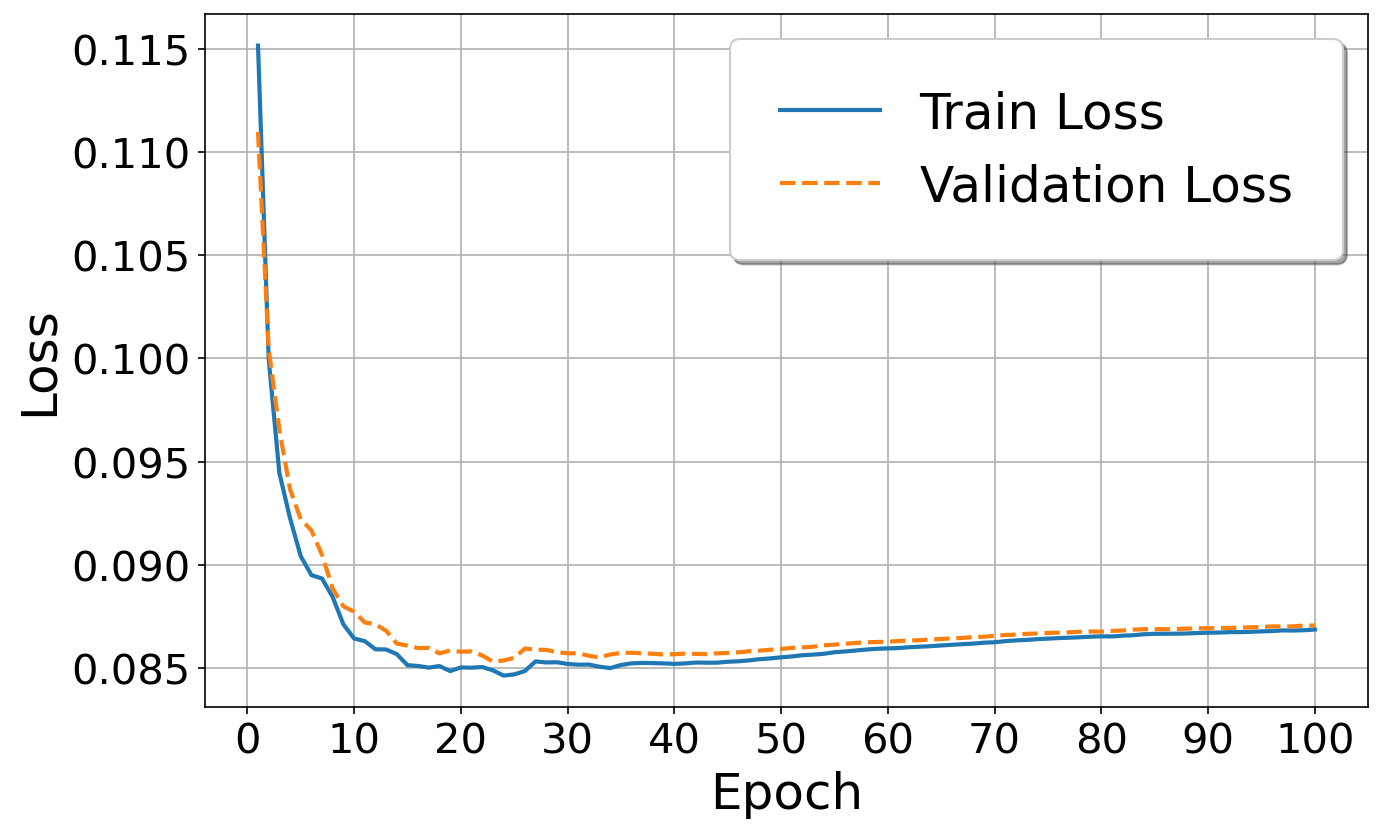

In [24]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


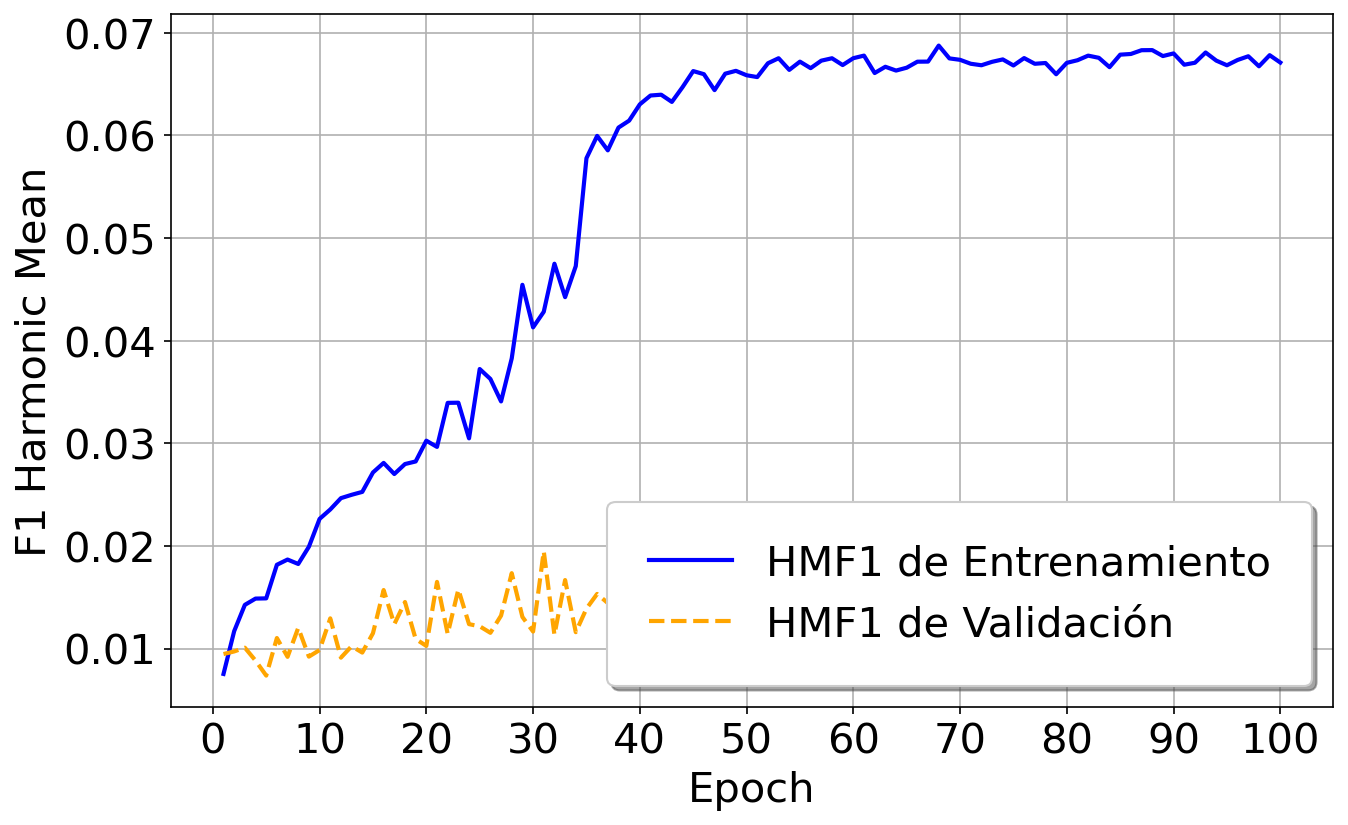

In [25]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

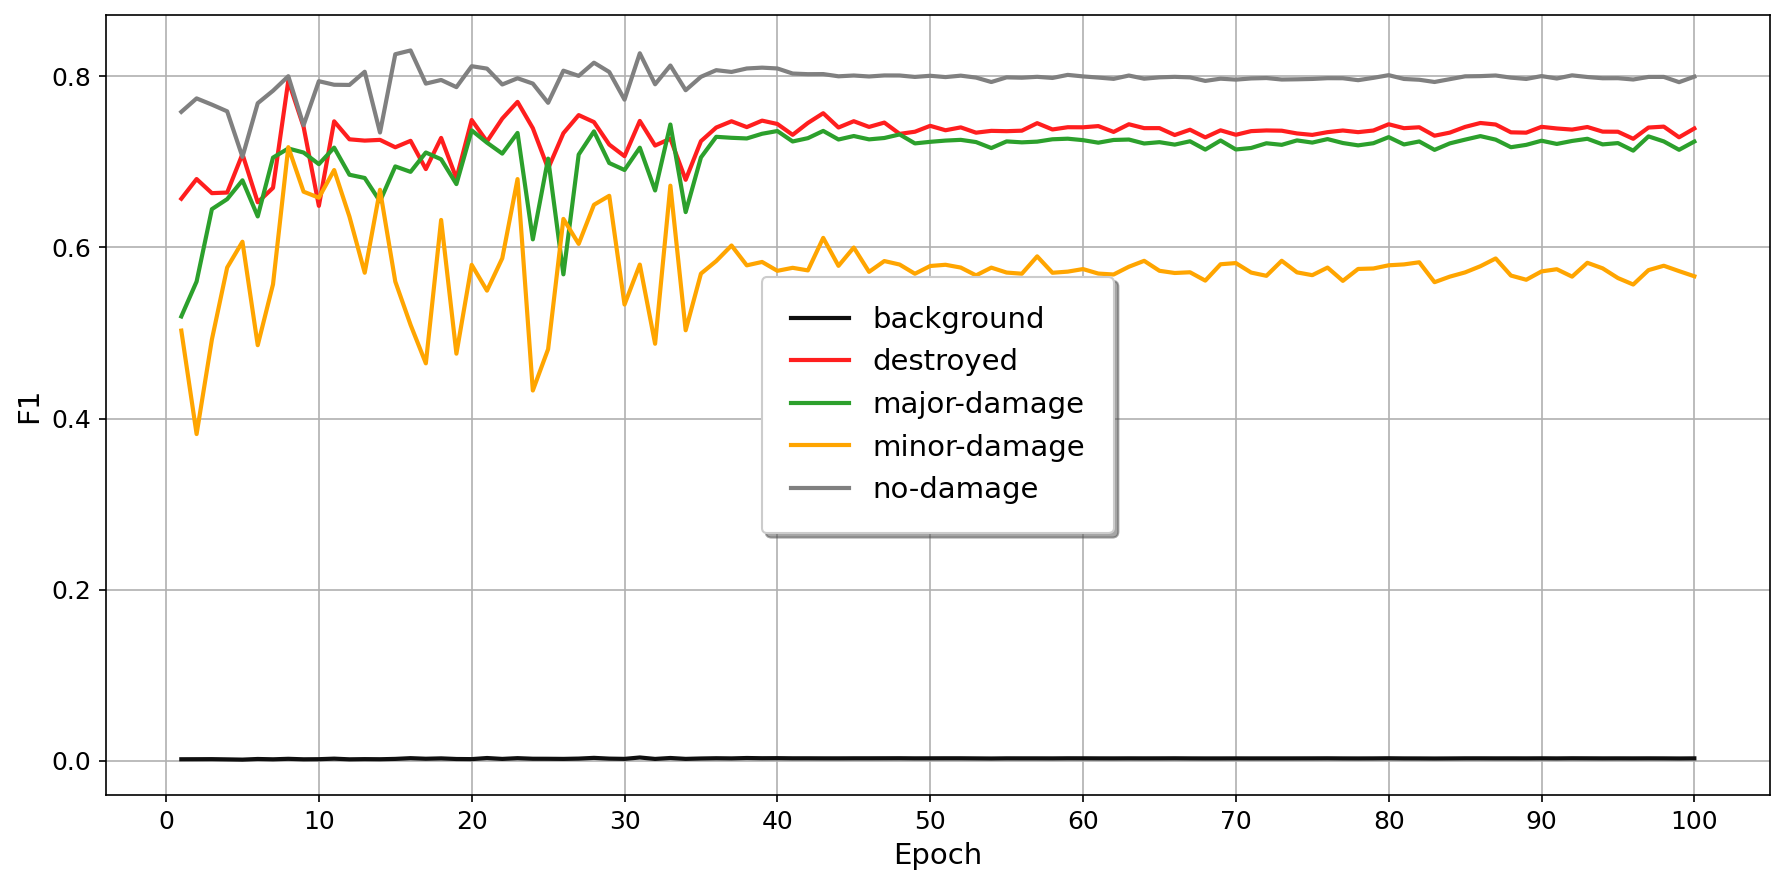

In [26]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",10)


# Experiment 4 with 50 epochs


In [27]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/out")

In [28]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,no-damage,7
1,minor-damage,15
2,major-damage,14
3,destroyed,14


In [29]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,1,0.0010,50
1,Config 1,1,0.0001,50
2,Config 2,4,0.0010,50
3,Config 3,4,0.0001,50
4,Config 4,8,0.0010,50
5,Config 5,8,0.0001,50
6,Config 6,16,0.0010,50
7,Config 7,16,0.0001,50


In [30]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0             1    2.1553    0.1898    0.0975
     F1             1    2.1750    0.0120    0.0475
     F2            31    1.7982    0.0847    0.0923
     F3             1    2.1603    0.1940    0.0952
C1   F0            33    1.7513    0.1247    0.1388
     F1            29    1.8431    0.0697    0.0712
     F2             3    1.9384    0.1179    0.0943
     F3            46    1.7470    0.1144    0.0899
C2   F0             1    0.5649    0.2711    0.1384
     F1            34    0.4532    0.3403    0.2542
     F2            26    0.4585    0.3466    0.2366
     F3             9    0.4838    0.2797    0.1626
     F4            16    0.4766    0.2435    0.1418
C3   F0            30    0.4194    0.4001    0.2869
     F1            17    0.4394    0.5163    0.3999
     F2            46    0.4061    0.4207    0.2820
     F3            49    0.4019    0.4265    0.2957
     F4             8    0.4652    0.3855    0.2395
C4   F0            30    0.2243    0.3197    0.1932
     F1            12    0.2340    0.4758    0.3455
     F2            19    0.2214    0.4860    0.3495
     F3            34    0.2124    0.4211    0.2758
     F4            26    0.2155    0.4580    0.3132
C5   F0            30    0.2067    0.4498    0.3080
     F1            18    0.2155    0.4689    0.3312
     F2            12    0.2260    0.5016    0.3706
     F3            33    0.2037    0.4714    0.3413
     F4            16    0.2178    0.4245    0.2750
C6   F0            26    0.1054    0.4850    0.3372
     F1            23    0.1067    0.5672    0.4523
     F2            35    0.1044    0.5653    0.4579
     F3            19    0.1099    0.5579    0.4693
     F4            12    0.1134    0.4202    0.2736
C7   F0            39    0.0986    0.5296    0.4103
     F1            30    0.1015    0.3754    0.2341
     F2             8    0.1190    0.5278    0.4049
     F3            19    0.1073    0.5152    0.3786
     F4            19    0.1094    0.5176    0.3961

In [31]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df, test_path)
print(header)
table

Mejor configuración = ('C6', 'F1') & Mejor época = 50 & val_loss = 0.096 & test_loss = 0.1117


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.556672 background       0.3108  0.5108  0.3864    0.9573
                    building         1.0000  0.9901  0.9950    0.9996
           0.740079 background       0.3108  0.5108  0.3864    0.9573
                    no-damage        0.9747  0.9591  0.9668    0.9992
                    minor-damage     0.9549  0.9573  0.9561    0.9993
                    major-damage     0.9643  0.9680  0.9662    0.9991
                    destroyed        0.9737  0.9267  0.9496    0.9992
test       0.320898 background       0.1608  0.2389  0.1922    0.7934
                    building         1.0000  0.9454  0.9719    0.9967
           0.438444 background       0.1608  0.2389  0.1922    0.7934
                    no-damage        0.7041  0.6811  0.6924    0.9907
                    minor-damage     0.4521  0.4404  0.4461    0.9904
                    major-damage     0.7386  0.7821  0.7597    0.9917
                    destroyed        0.9118  0.7691  0.8344    0.9956

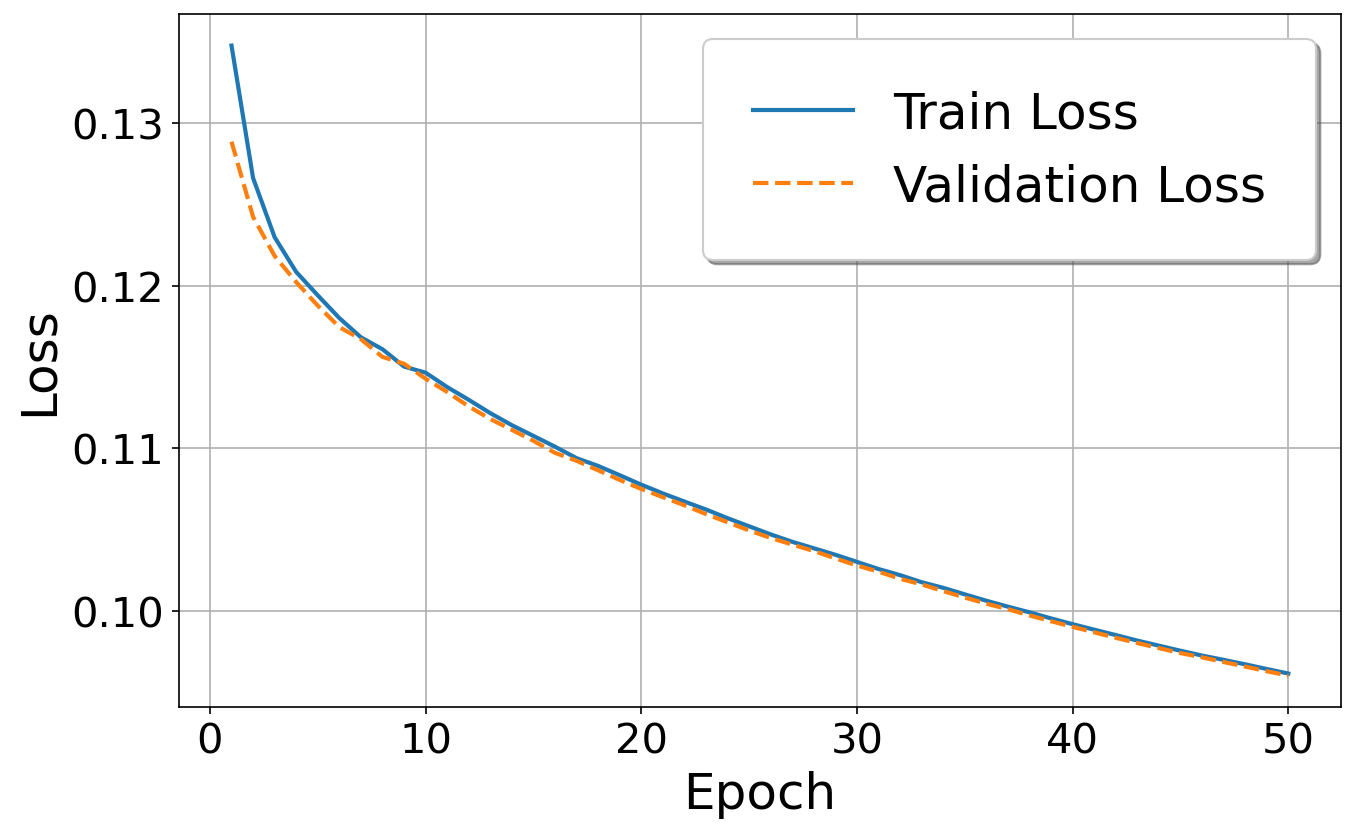

In [32]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df,10)


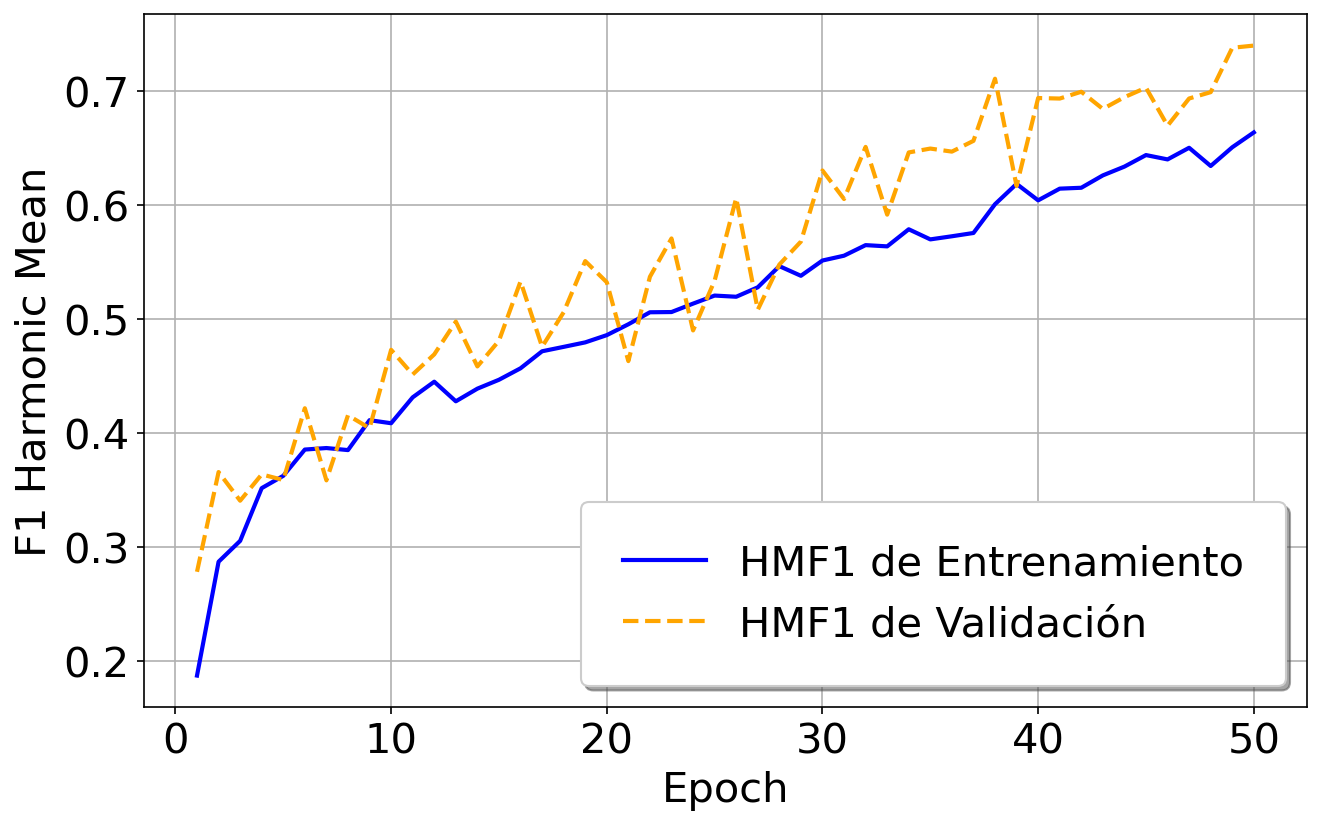

In [33]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,10)

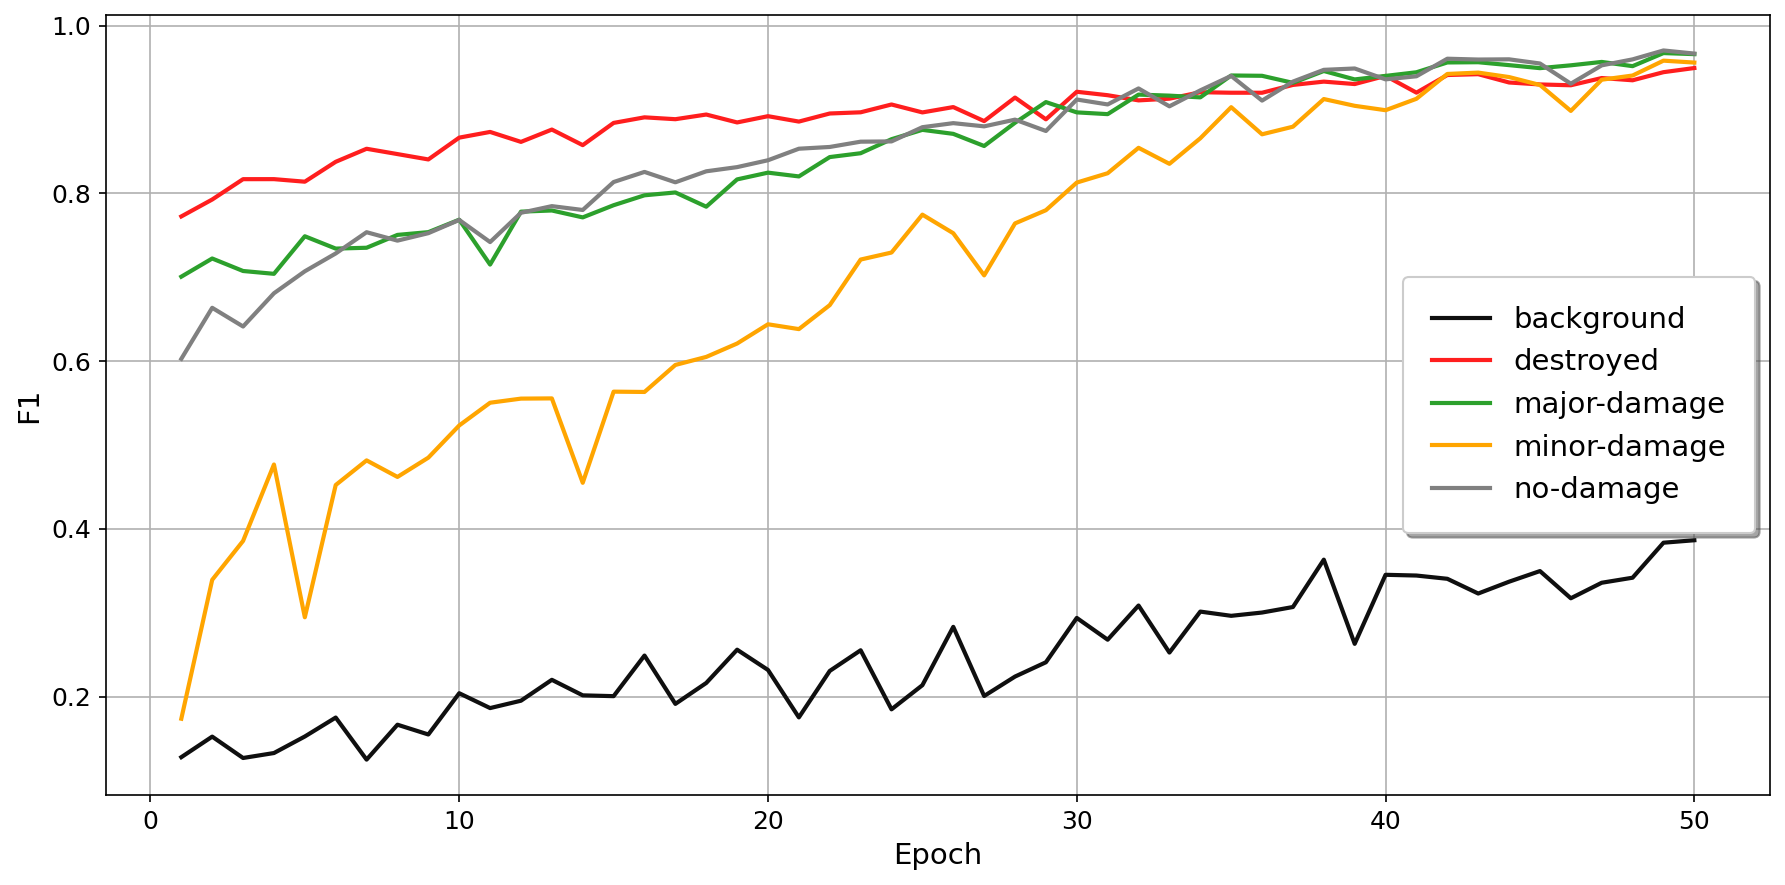

In [34]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",10)


# Experiment 4 with 200 epochs

In [35]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_200/out")

In [36]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,background,2
1,no-damage,7
2,minor-damage,15
3,major-damage,14
4,destroyed,14


In [37]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.001,200


In [38]:
fold_df = build_fold_table(path)
fold_df

,Fold,Best epoch,val-loss,HMf1-dmg,HFM1-seg
Conf,,,,,


In [39]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df, test_path)
print(header)
table

Mejor configuración = 0 & Mejor época = 193 & val_loss = 0.0863 & test_loss = 0.1263


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.660971 background       0.3510  0.8612  0.4987    0.7631
                    building         1.0000  0.9603  0.9797    0.9983
           0.819918 background       0.3510  0.8612  0.4987    0.7631
                    no-damage        0.9956  0.9641  0.9796    0.9995
                    minor-damage     0.9956  0.9548  0.9748    0.9996
                    major-damage     0.9961  0.9604  0.9779    0.9994
                    destroyed        0.9961  0.9584  0.9769    0.9996
test       0.287038 background       0.0989  0.6369  0.1712    0.4988
                    building         1.0000  0.7968  0.8869    0.9904
           0.409610 background       0.0989  0.6369  0.1712    0.4988
                    no-damage        0.7731  0.5852  0.6662    0.9931
                    minor-damage     0.7114  0.3336  0.4542    0.9899
                    major-damage     0.6816  0.7308  0.7053    0.9909
                    destroyed        0.8578  0.7539  0.8025    0.9973

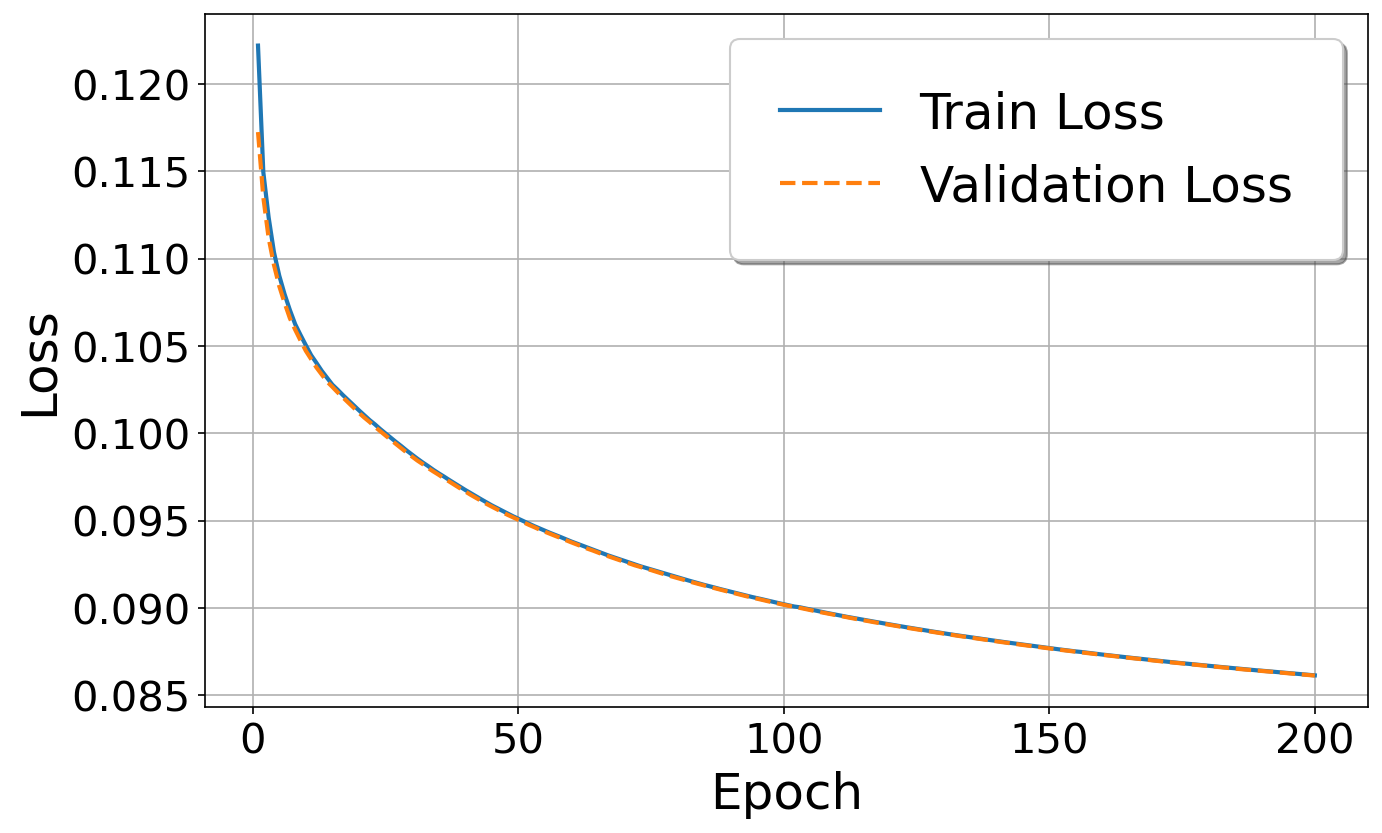

In [40]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 50)


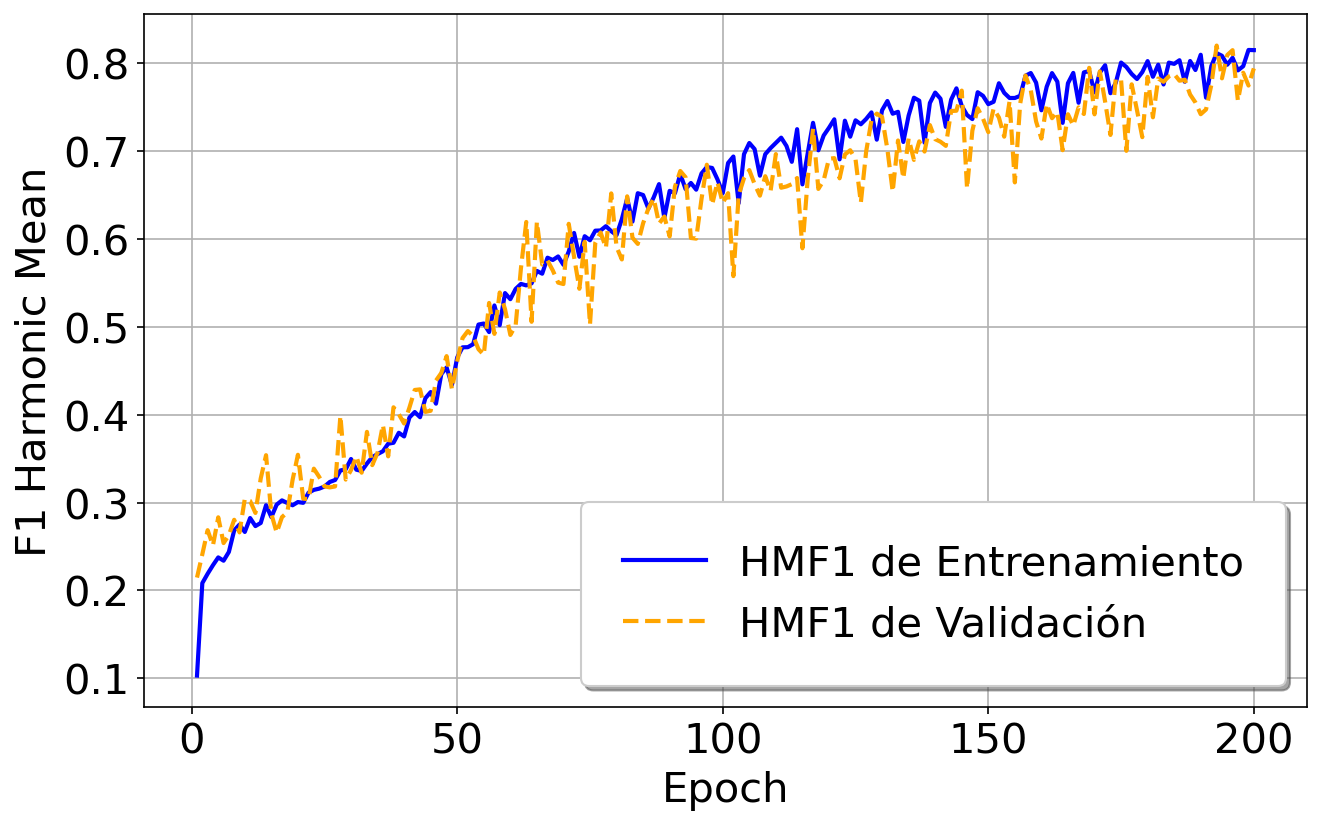

In [41]:
dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df,50)

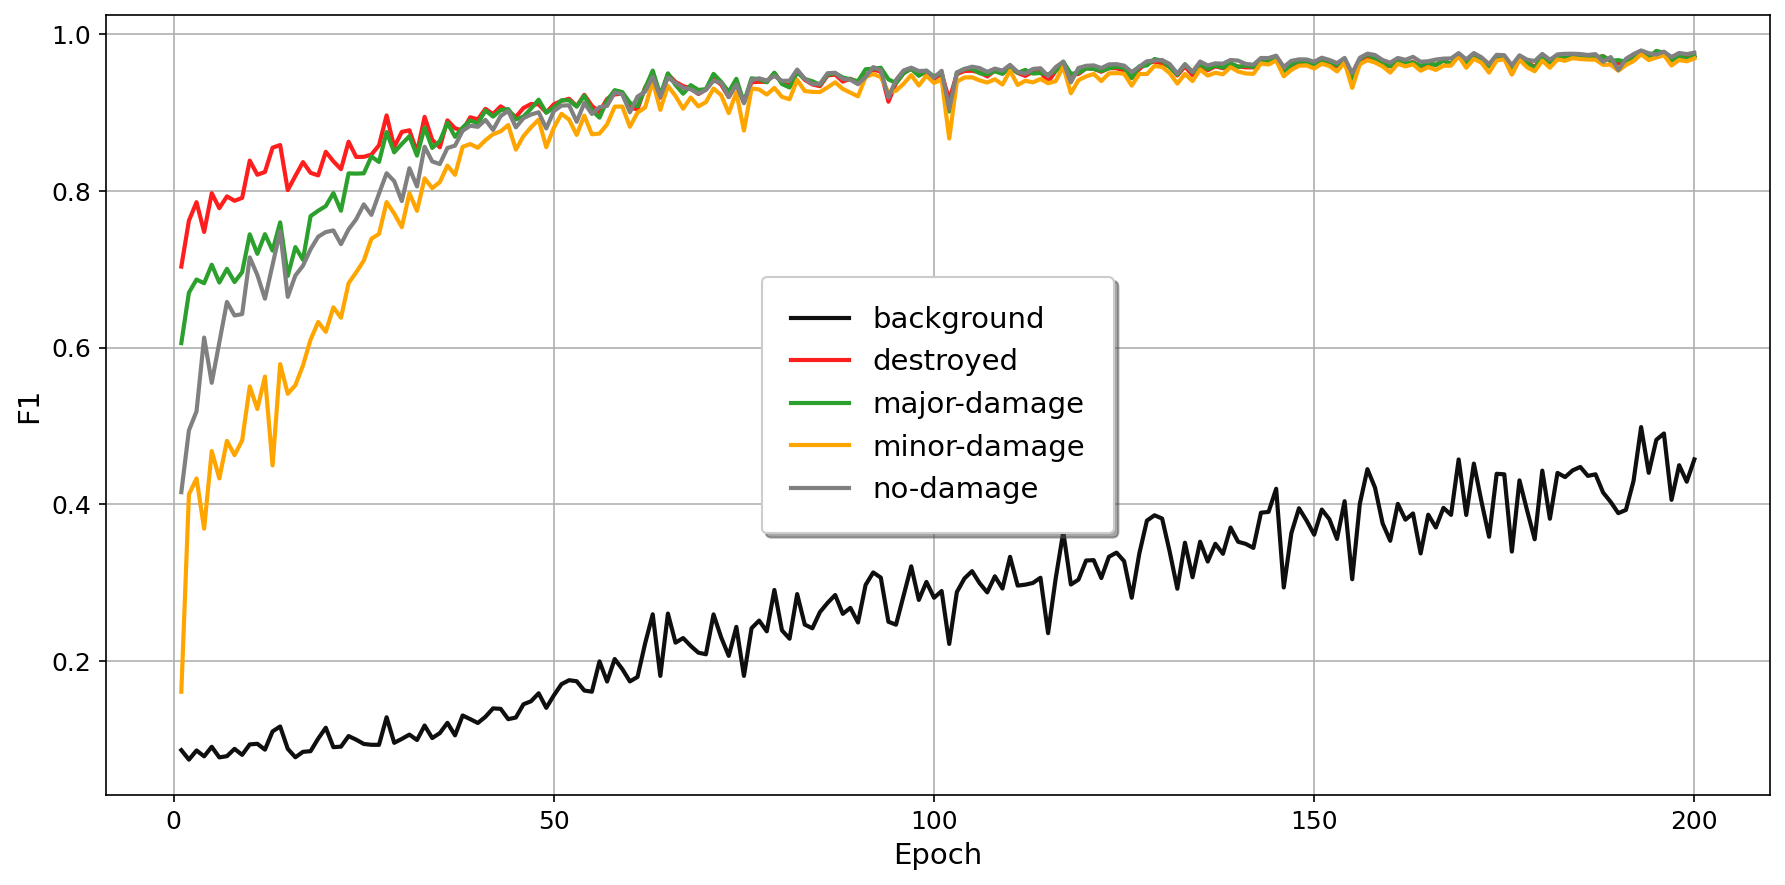

In [42]:
#val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1",50)


# Experiment 4 with 400 epochs

In [43]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_400/out")

In [44]:
wei_df = build_weights_table(path)
wei_df

,Class,Weight
0,background,2
1,no-damage,7
2,minor-damage,15
3,major-damage,14
4,destroyed,14


In [45]:
params_df = build_conf_table(path)
params_df

,Number,Batch size,Learning rate,Total epochs
0,Config 0,16,0.001,400


In [46]:
fold_df = build_fold_table(path)
fold_df

,Fold,Best epoch,val-loss,HMf1-dmg,HFM1-seg
Conf,,,,,


In [47]:
test_path = FilePath("definitive_model/best_metrics/csv/")
header, table = build_val_test_table(path, fold_df, test_path)
print(header)
table

Mejor configuración = 0 & Mejor época = 344 & val_loss = 0.0803 & test_loss = 0.1405


precision  recall      f1  accuracy
split      hf1      class                                            
validation 0.688899 background       0.3755  0.9056  0.5309    0.6846
                    building         1.0000  0.9625  0.9809    0.9984
           0.837862 background       0.3755  0.9056  0.5309    0.6846
                    no-damage        0.9975  0.9691  0.9831    0.9996
                    minor-damage     0.9975  0.9571  0.9769    0.9996
                    major-damage     0.9971  0.9607  0.9786    0.9994
                    destroyed        0.9981  0.9614  0.9794    0.9996
test       0.253130 background       0.0837  0.6547  0.1484    0.3831
                    building         1.0000  0.7533  0.8593    0.9884
           0.369750 background       0.0837  0.6547  0.1484    0.3831
                    no-damage        0.7805  0.5431  0.6405    0.9929
                    minor-damage     0.7016  0.2812  0.4015    0.9895
                    major-damage     0.6702  0.6972  0.6835    0.9904
                    destroyed        0.8647  0.7224  0.7872    0.9971

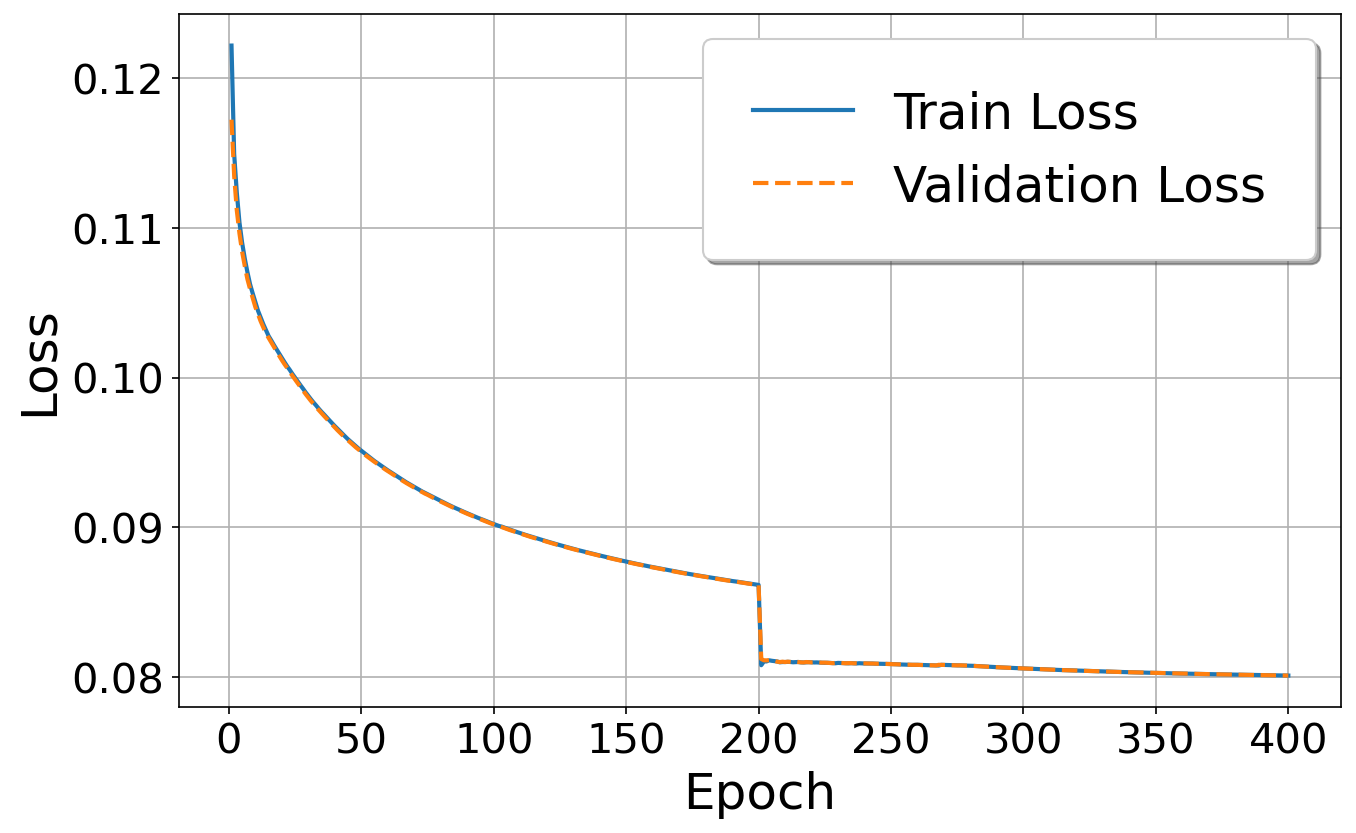

In [48]:
def_metric_dir = path.join("definitive_model/metrics/csv")

#loss_plots
loss_train_df_400 = pd.read_csv(def_metric_dir.join("train_loss.csv")).set_index("epoch")
loss_train_df = pd.concat([loss_train_df,loss_train_df_400])
loss_val_df_400 = pd.read_csv(def_metric_dir.join("val_loss.csv")).set_index("epoch")
loss_val_df = pd.concat([loss_val_df,loss_val_df_400])

plot_loss(loss_train_df, loss_val_df,50)


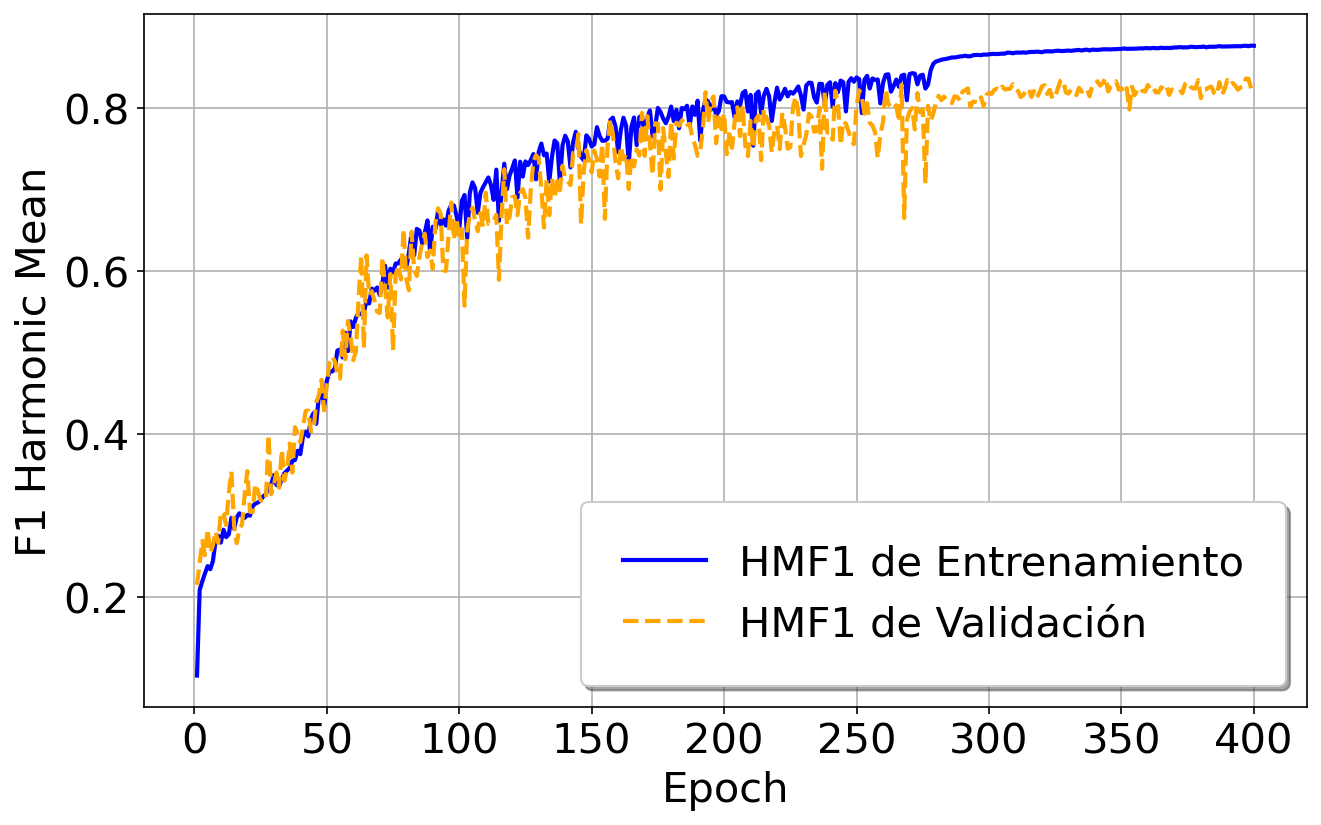

In [49]:
dmg_train_df_400 = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_train_df = pd.concat([dmg_train_df, dmg_train_df_400]).reset_index(drop=True)

prev_path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_200/out")
dmg_val_df_200 = pd.read_csv(prev_path.join("definitive_model/metrics/csv/val_dmg_pixel_level.csv"))
dmg_val_df_400 = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
dmg_val_df = pd.concat([dmg_val_df_200, dmg_val_df_400]).reset_index(drop=True)

plot_harmonic_mean(dmg_train_df, dmg_val_df, 50)

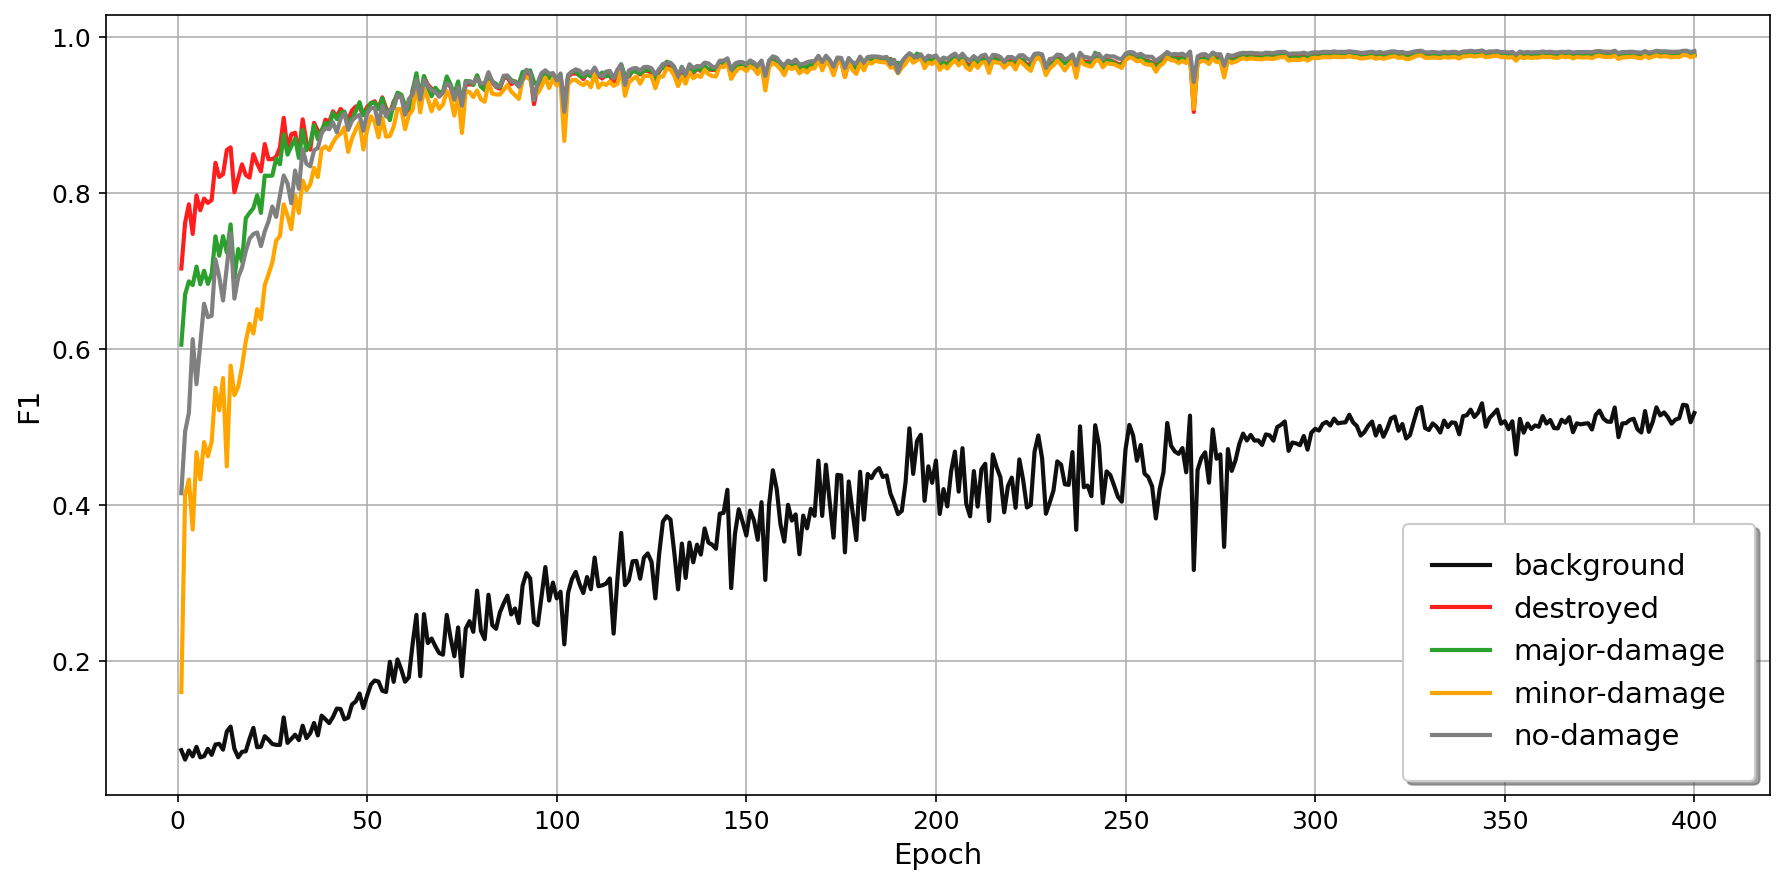

In [50]:
#val_f1_plots
plot_metric_per_class(dmg_val_df, "f1",50)


# Object level evaluation

In [51]:
conf_path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp5_noh_400/out/postprocessing/metrics/obj_multi_confusion_matrix.csv")
conf = pd.read_csv(conf_path)
conf = conf.drop(columns=["5"]).drop(index=[4]).loc[[0,1,2,3,6,5],["1","2","3","4","Undetected","Total"]]
conf = conf.set_axis(["no-damage","minor-damage","major-damage","destroyed","Ghost","Total"])
conf.columns = ["no-damage","minor-damage","major-damage","destroyed","Undetected","Total"]
conf.loc["Total","Total"] = 0
conf.loc["Ghost","Total"] = 0
conf.loc["Ghost","Total"] = conf.loc[:,"Total"].sum()
conf.loc["Total","Undetected"] = 0
conf.loc["Total","Undetected"] = conf.loc["Total"].sum()
conf

FileNotFoundError: [Errno 2] No such file or directory: '/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp5_noh_400/out/postprocessing/metrics/obj_multi_confusion_matrix.csv'

In [ ]:
print(conf.to_latex())